# Flood Detection using Deep Learning (Finetuning MobileNet, KERAS)

In [1]:
# Loading required libraries and functions
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

Using TensorFlow backend.


In [2]:
# Loading data and preprocessing images according to mobilenet requirements
# Creating batches of data

labels = ['Flooding', 'No Flooding']
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 321 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [3]:
#Loading pre-trained lightweight mobilenet image classifier
mobile = tf.keras.applications.mobilenet.MobileNet()
# mobile.summary()

W0826 17:51:10.586108 4425418176 deprecation.py:506] From /anaconda3/envs/python_3_gpss/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
# Store all layers of the original mobilenet except the last 5 layers in variable x
# There is no predefined logic behind this, it just gives the optimal results for this task
# Also, we will be only training the last 5 layers of the mobilenet during finetuning as we want 
# it to keep all of the previously learned weights 
x = mobile.layers[-6].output

In [5]:
# Create an output layer with binary output layer, as we want our model to be a binary classifier, 
# i.e. to classify flooding and no flooding
output = Dense(units=2, activation='softmax')(x)

In [6]:
# Construct the new fine-tuned mode
model = Model(inputs=mobile.input, outputs=output)

In [7]:
# Freez weights of all the layers except for the last five layers in our new model, 
# meaning that only the last five layers of the model will be trained.
for layer in model.layers[:-23]:
    layer.trainable = False

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [9]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the Model

model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

In [11]:
# Saving and loading our trained for future use

model.save("fine_tuned_flood_detection_model")
# model.load_weights('fine_tuned_flood_detection_model')

In [12]:
# Make predictions and plot confusion matrix to look how well our model performed in classifying 
# flooding and no flooding images 

test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# Pring precision, F1 score and accuracy of our model
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.9655172413793104
F1 Score:  0.9824561403508771
Accuracy:  0.9859154929577465


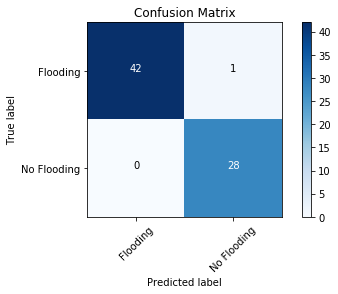

In [14]:
# Confusion Matrix 
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Evaluate our finetuned model

In [15]:
# Prepare image for mobilenet prediction

def preprocess_image(file):
    img_path = 'evaluate/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

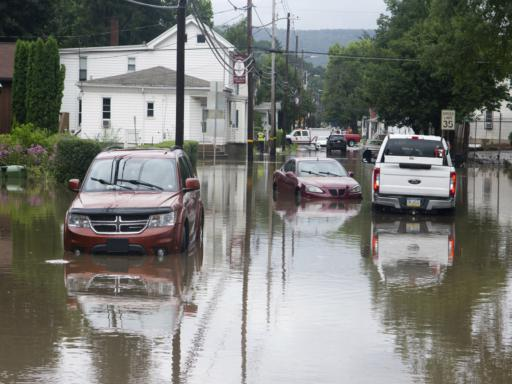

In [16]:
# Display image which we want to predict
from IPython.display import Image
Image(filename='evaluate/1.jpg', width=300,height=200) 

In [17]:
# Preprocess image and make prediction

preprocessed_image = preprocess_image('1.jpg')
predictions = model.predict(preprocessed_image)

In [18]:
# Print predicted accuracy scores for both classes, i.e. (1) Flooding, (2) No Flooding
predictions

array([[9.9999964e-01, 3.5521168e-07]], dtype=float32)

In [19]:
# Get the maximum probability score for predicted class from predictions array
result = np.argmax(predictions)

In [20]:
# Print the predicted class label
labels[result]

'Flooding'

NOTE, This code was inspired and modified from the following source: 
https://deeplizard.com/.


Flooding images were collected from paper named "Detecting floodwater on roadways from image data with handcrafted features and deep transfer learning*", available at "https://arxiv.org/pdf/1909.00125.pdf". 

Funfact: This model outperforms the model presented in the paper.

Normal or No Flooding images were collected from google image search, there may be irrelevant images in this category
because the images were downloaded using an automated script. 

The trained model performed quite impressively and got an accuracy score of over 98%.